<a href="https://colab.research.google.com/github/raj-kariya/Test-Case-Generation-using-LLM/blob/main/Compare_CFGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
class CFGBuilder(ast.NodeVisitor):
    def __init__(self):
        self.cfg = nx.DiGraph()
        self.current_node = None
        self.node_count = 0
        self.node_map = {}
        self.depth = 0  # Track the depth of each node for layout

    def add_node(self, label):
        self.node_count += 1
        node_name = f"N{self.node_count}"
        self.cfg.add_node(node_name, label=self.node_count, subset=self.depth, label_str=label)
        self.node_map[self.node_count] = label
        if self.current_node:
            self.cfg.add_edge(self.current_node, node_name)
        self.current_node = node_name
        return node_name

    def visit_FunctionDef(self, node):
        entry_node = self.add_node("entry")
        self.depth += 1
        self.current_node = entry_node
        self.generic_visit(node)
        self.add_node("exit")
        self.depth -= 1

    def visit_Assign(self, node):
        targets = [ast.unparse(t) for t in node.targets]
        value = ast.unparse(node.value)
        self.add_node(f"{targets[0]} = {value}")

    def visit_If(self, node):
        cond = ast.unparse(node.test)
        cond_node = self.add_node(f"if {cond}")
        current_node = self.current_node

        # Visit the body of the if statement
        self.depth += 1
        self.current_node = cond_node
        for stmt in node.body:
            self.visit(stmt)
        if_body_end = self.current_node

        # Visit the else part, if it exists
        self.current_node = cond_node
        else_node = self.add_node("else")
        if node.orelse:
            self.current_node = else_node
            for stmt in node.orelse:
                self.visit(stmt)
        else_body_end = self.current_node
        self.depth -= 1

        # Add a join node after if-else
        join_node = self.add_node("join")
        self.cfg.add_edge(if_body_end, join_node)
        self.cfg.add_edge(else_body_end, join_node)
        self.current_node = join_node

    def visit_While(self, node):
        cond = ast.unparse(node.test)
        cond_node = self.add_node(f"while {cond}")
        current_node = self.current_node

        # Visit the body of the while loop
        self.depth += 1
        for stmt in node.body:
            self.visit(stmt)
        body_end = self.current_node

        # Loop back to the condition node
        self.cfg.add_edge(body_end, cond_node)
        self.current_node = cond_node
        self.depth -= 1

    def visit_For(self, node):
        target = ast.unparse(node.target)
        iter_ = ast.unparse(node.iter)
        cond_node = self.add_node(f"for {target} in {iter_}")
        current_node = self.current_node

        # Visit the body of the for loop
        self.depth += 1
        for stmt in node.body:
            self.visit(stmt)
        body_end = self.current_node

        # Loop back to the condition node
        self.cfg.add_edge(body_end, cond_node)
        self.current_node = cond_node
        self.depth -= 1

    def visit_Return(self, node):
        value = ast.unparse(node.value)
        self.add_node(f"return {value}")

In [ ]:
def generate_cfg(source_code):
    tree = ast.parse(source_code)
    cfg_builder = CFGBuilder()
    cfg_builder.visit(tree)
    return cfg_builder.cfg, cfg_builder.node_map

In [ ]:
def visualize_cfg(cfg, title):
    pos = nx.multipartite_layout(cfg, subset_key="subset")
    plt.figure(figsize=(12, 8))
    labels = nx.get_node_attributes(cfg, 'label')
    edge_labels = {(u, v): cfg[u][v].get('label', '') for u, v in cfg.edges()}
    nx.draw(cfg, pos, with_labels=True, labels=labels, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
    nx.draw_networkx_edge_labels(cfg, pos, edge_labels=edge_labels, font_color='red')
    plt.title(title)
    plt.show()

In [ ]:
def print_node_map(node_map):
    print("Node Number to Syntax Mapping:")
    for node, syntax in node_map.items():
        print(f"{node}: {syntax}")

In [ ]:
def compare_cfgs(cfg1, cfg2):
    def hashable_nodes(cfg):
        return set((node, frozenset(data.items())) for node, data in cfg.nodes(data=True))

    def hashable_edges(cfg):
        return set((u, v, frozenset(data.items())) for u, v, data in cfg.edges(data=True))

    # Compare nodes
    nodes1 = hashable_nodes(cfg1)
    nodes2 = hashable_nodes(cfg2)
    common_nodes = nodes1 & nodes2
    added_nodes = nodes2 - nodes1
    removed_nodes = nodes1 - nodes2

    # Compare edges
    edges1 = hashable_edges(cfg1)
    edges2 = hashable_edges(cfg2)
    common_edges = edges1 & edges2
    added_edges = edges2 - edges1
    removed_edges = edges1 - edges2

    print("Common Nodes:")
    for node in common_nodes:
        print(node)

    print("\nAdded Nodes:")
    for node in added_nodes:
        print(node)

    print("\nRemoved Nodes:")
    for node in removed_nodes:
        print(node)

    print("\nCommon Edges:")
    for edge in common_edges:
        print(edge)

    print("\nAdded Edges:")
    for edge in added_edges:
        print(edge)

    print("\nRemoved Edges:")
    for edge in removed_edges:
        print(edge)


In [ ]:
def calculate_independent_paths(cfg):
    e = cfg.number_of_edges()
    n = cfg.number_of_nodes()
    independent_paths = e - n + 2
    return independent_paths

In [ ]:
def execute_test_case(cfg, test_case):
    current_node = 'N1'  # Assuming 'N1' is the entry node
    visited_nodes = [current_node]

    while current_node != 'N2':  # Assuming 'N2' is the exit node
        neighbors = list(cfg.successors(current_node))
        if not neighbors:
            break
        next_node = None
        for neighbor in neighbors:
            condition = cfg.nodes[neighbor].get('label_str', '')
            if isinstance(condition, str) and ('if' in condition or 'while' in condition):
                cond = condition.split(' ', 1)[1]
                try:
                    cond_value = eval(cond, {'test_case': test_case})
                except Exception as e:
                    cond_value = False
                if cond_value:
                    next_node = neighbor
                    break
            else:
                next_node = neighbor
        if next_node is None:
            break
        current_node = next_node
        visited_nodes.append(current_node)

    return visited_nodes

In [ ]:
def map_test_cases_to_nodes(cfg, test_cases):
    node_test_case_map = {node: [] for node in cfg.nodes}
    for test_case in test_cases:
        visited_nodes = execute_test_case(cfg, test_case)
        for node in visited_nodes:
            node_test_case_map[node].append(test_case)
    return node_test_case_map


def generate_test_cases():
    return [
        {'number': 1},    # Example test cases
        {'number': -1},
        {'number': 0},
        {'number': 2}
    ]

In [ ]:
# Example usage with different code versions
version1 = """
def process_numbers(numbers):
    total = 0
    for number in numbers:
        if number > 0:
            total += number
        else:
            total -= number
    return total
"""

version2 = """
def process_numbers(numbers):
    total = 0
    for number in numbers:
        if number > 0:
            total += number
        elif number < 0:
            total -= number
        else:
            total += 1  # Change: handling zero differently
    return total
"""


CFG for Version 1:


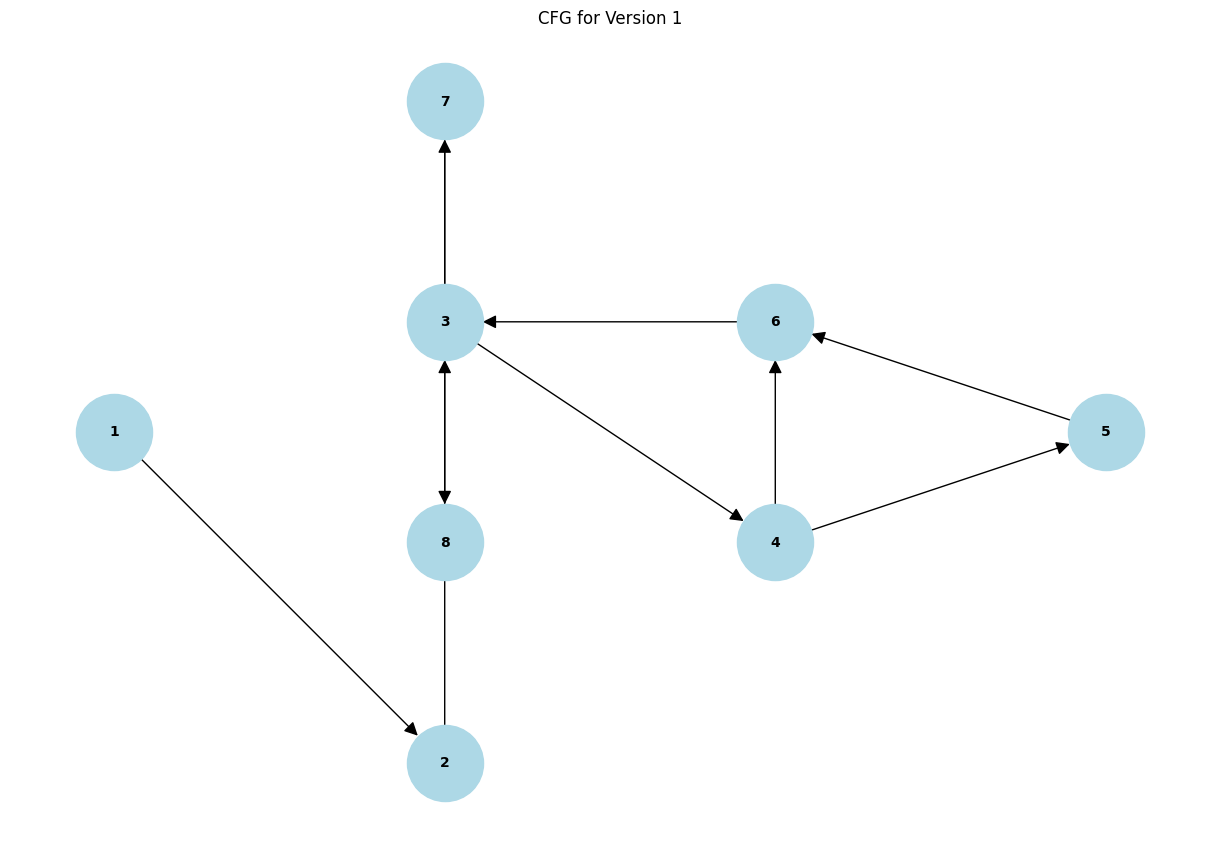

Node Number to Syntax Mapping:
1: entry
2: total = 0
3: for number in numbers
4: if number > 0
5: else
6: join
7: return total
8: exit
Number of independent paths for Version 1: 3

CFG for Version 2:


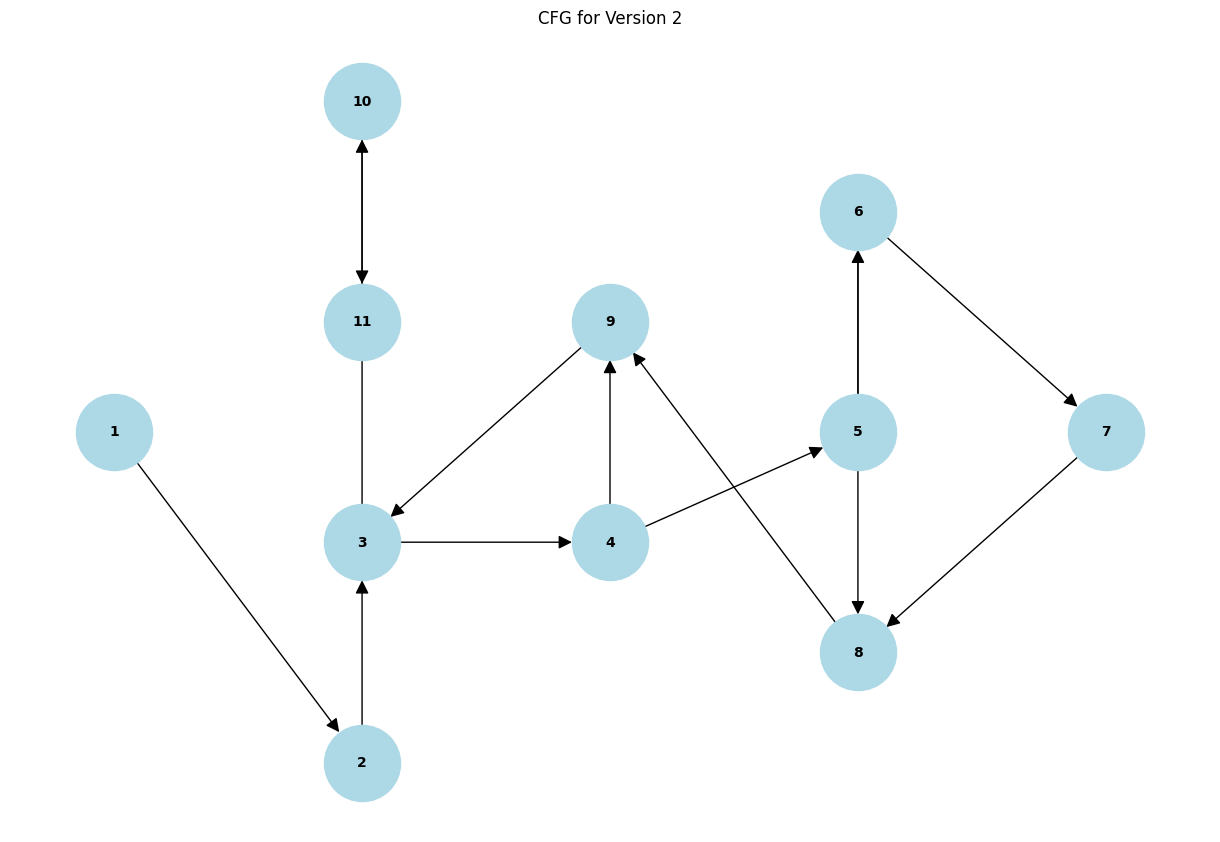

Node Number to Syntax Mapping:
1: entry
2: total = 0
3: for number in numbers
4: if number > 0
5: else
6: if number < 0
7: else
8: join
9: join
10: return total
11: exit
Number of independent paths for Version 2: 4

Comparison of CFGs (Version 1 and Version 2):
Common Nodes:
('N3', frozenset({('subset', 1), ('label_str', 'for number in numbers'), ('label', 3)}))
('N5', frozenset({('label', 5), ('label_str', 'else'), ('subset', 3)}))
('N2', frozenset({('subset', 1), ('label_str', 'total = 0'), ('label', 2)}))
('N4', frozenset({('label', 4), ('subset', 2), ('label_str', 'if number > 0')}))
('N1', frozenset({('subset', 0), ('label', 1), ('label_str', 'entry')}))

Added Nodes:
('N7', frozenset({('label_str', 'else'), ('label', 7), ('subset', 4)}))
('N6', frozenset({('label_str', 'if number < 0'), ('label', 6), ('subset', 3)}))
('N10', frozenset({('label', 10), ('label_str', 'return total'), ('subset', 1)}))
('N9', frozenset({('label', 9), ('label_str', 'join'), ('subset', 2)}))
('N8', froz

In [ ]:
cfg1, node_map1 = generate_cfg(version1)
cfg2, node_map2 = generate_cfg(version2)

print("CFG for Version 1:")
visualize_cfg(cfg1, "CFG for Version 1")
print_node_map(node_map1)
independent_paths1 = calculate_independent_paths(cfg1)
print(f"Number of independent paths for Version 1: {independent_paths1}")

print("\nCFG for Version 2:")
visualize_cfg(cfg2, "CFG for Version 2")
print_node_map(node_map2)
independent_paths2 = calculate_independent_paths(cfg2)
print(f"Number of independent paths for Version 2: {independent_paths2}")

print("\nComparison of CFGs (Version 1 and Version 2):")
compare_cfgs(cfg1, cfg2)

# Example usage of test case mapping
test_cases = generate_test_cases()
node_test_case_map1 = map_test_cases_to_nodes(cfg1, test_cases)
node_test_case_map2 = map_test_cases_to_nodes(cfg2, test_cases)

# print("Test Case to Node Mapping for Version 1:", node_test_case_map1)
# print("Test Case to Node Mapping for Version 2:", node_test_case_map2)


CFG for Version 1:


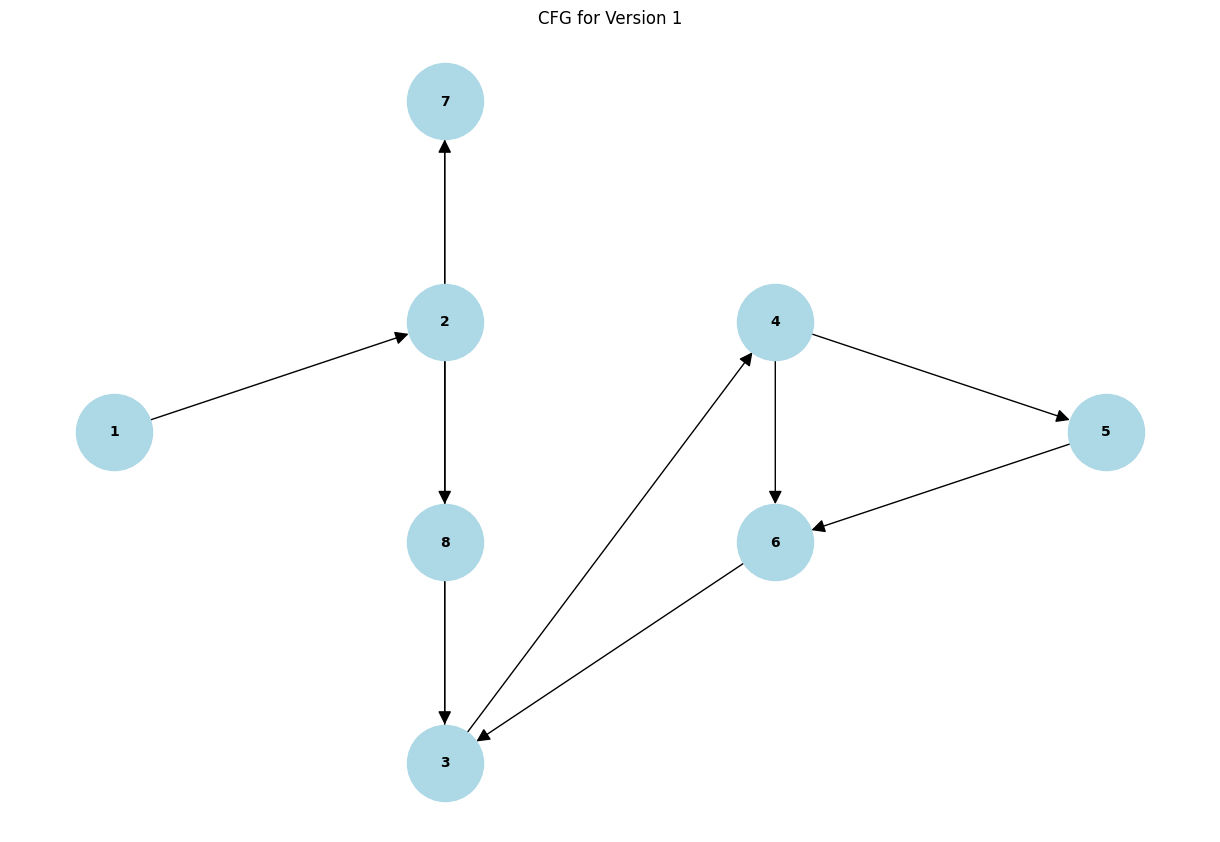

Node Number to Syntax Mapping:
1: entry
2: total = 0
3: for number in numbers
4: if number > 0
5: else
6: join
7: return total
8: exit
Number of independent paths for Version 1: 3

CFG for Version 2:


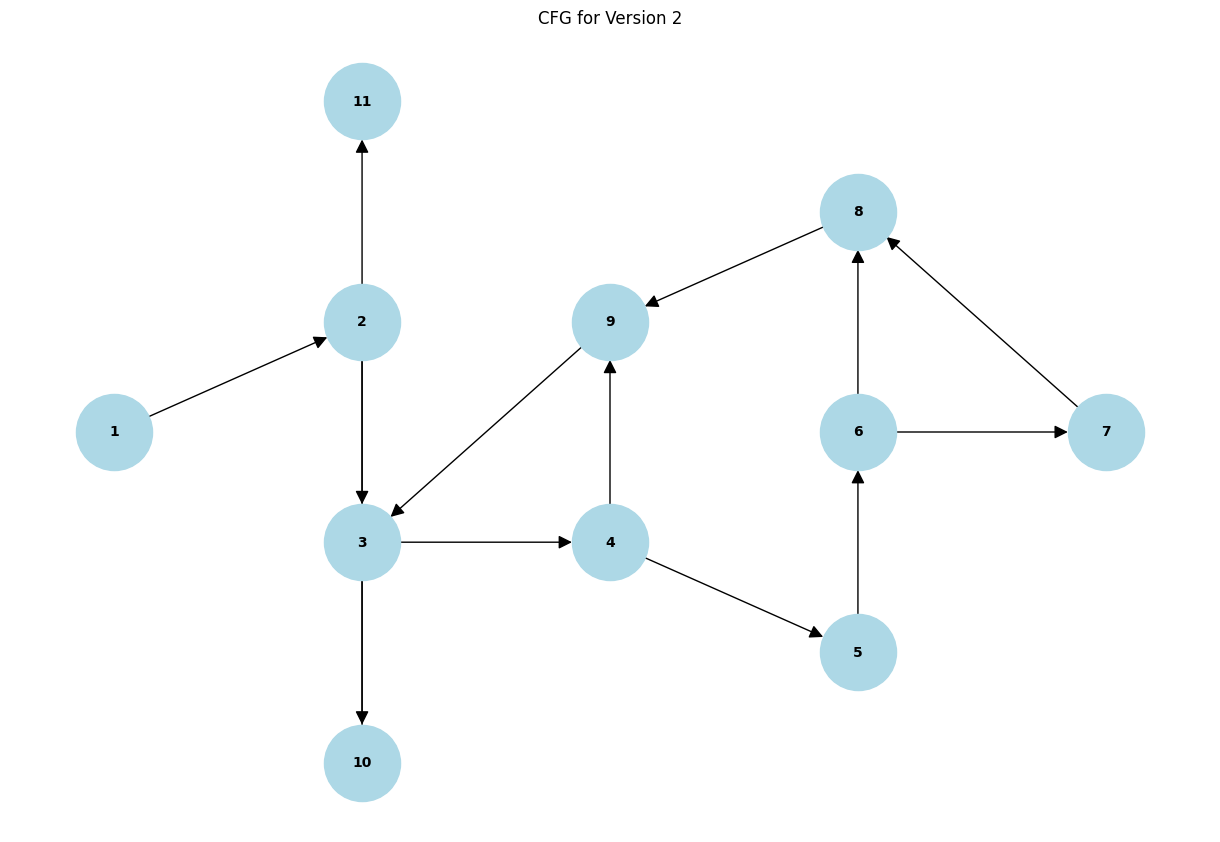

Node Number to Syntax Mapping:
1: entry
2: total = 0
3: for number in numbers
4: if number > 0
5: else
6: if number < 0
7: else
8: join
9: join
10: return total
11: exit
Number of independent paths for Version 2: 4

Comparison of CFGs (Version 1 and Version 2):
Common Nodes:
('N4', frozenset({('label', 4), ('label_str', 'if number > 0'), ('subset', 2)}))
('N3', frozenset({('label', 3), ('subset', 1), ('label_str', 'for number in numbers')}))
('N2', frozenset({('label_str', 'total = 0'), ('subset', 1), ('label', 2)}))
('N1', frozenset({('subset', 0), ('label', 1), ('label_str', 'entry')}))
('N5', frozenset({('subset', 3), ('label_str', 'else'), ('label', 5)}))

Added Nodes:
('N6', frozenset({('subset', 3), ('label_str', 'if number < 0'), ('label', 6)}))
('N8', frozenset({('subset', 3), ('label_str', 'join'), ('label', 8)}))
('N11', frozenset({('label_str', 'exit'), ('label', 11), ('subset', 1)}))
('N10', frozenset({('label', 10), ('subset', 1), ('label_str', 'return total')}))
('N9', fr

In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

class CFGBuilder(ast.NodeVisitor):
    def __init__(self):
        self.cfg = nx.DiGraph()
        self.current_node = None
        self.node_count = 0
        self.node_map = {}
        self.depth = 0  # Track the depth of each node for layout

    def add_node(self, label):
        self.node_count += 1
        node_name = f"N{self.node_count}"
        self.cfg.add_node(node_name, label=self.node_count, subset=self.depth, label_str=label)
        self.node_map[self.node_count] = label
        if self.current_node:
            self.cfg.add_edge(self.current_node, node_name)
        self.current_node = node_name
        return node_name

    def visit_FunctionDef(self, node):
        entry_node = self.add_node("entry")
        self.depth += 1
        self.current_node = entry_node
        self.generic_visit(node)
        self.add_node("exit")
        self.depth -= 1

    def visit_Assign(self, node):
        targets = [ast.unparse(t) for t in node.targets]
        value = ast.unparse(node.value)
        self.add_node(f"{targets[0]} = {value}")

    def visit_If(self, node):
        cond = ast.unparse(node.test)
        cond_node = self.add_node(f"if {cond}")
        current_node = self.current_node

        # Visit the body of the if statement
        self.depth += 1
        self.current_node = cond_node
        for stmt in node.body:
            self.visit(stmt)
        if_body_end = self.current_node

        # Visit the else part, if it exists
        self.current_node = cond_node
        else_node = self.add_node("else")
        if node.orelse:
            self.current_node = else_node
            for stmt in node.orelse:
                self.visit(stmt)
        else_body_end = self.current_node
        self.depth -= 1

        # Add a join node after if-else
        join_node = self.add_node("join")
        self.cfg.add_edge(if_body_end, join_node)
        self.cfg.add_edge(else_body_end, join_node)
        self.current_node = join_node

    def visit_While(self, node):
        cond = ast.unparse(node.test)
        cond_node = self.add_node(f"while {cond}")
        current_node = self.current_node

        # Visit the body of the while loop
        self.depth += 1
        for stmt in node.body:
            self.visit(stmt)
        body_end = self.current_node

        # Loop back to the condition node
        self.cfg.add_edge(body_end, cond_node)
        self.current_node = cond_node
        self.depth -= 1

    def visit_For(self, node):
        target = ast.unparse(node.target)
        iter_ = ast.unparse(node.iter)
        cond_node = self.add_node(f"for {target} in {iter_}")
        current_node = self.current_node

        # Visit the body of the for loop
        self.depth += 1
        for stmt in node.body:
            self.visit(stmt)
        body_end = self.current_node

        # Loop back to the condition node
        self.cfg.add_edge(body_end, cond_node)
        self.current_node = cond_node
        self.depth -= 1

    def visit_Return(self, node):
        value = ast.unparse(node.value)
        self.add_node(f"return {value}")

def generate_cfg(source_code):
    tree = ast.parse(source_code)
    cfg_builder = CFGBuilder()
    cfg_builder.visit(tree)
    return cfg_builder.cfg, cfg_builder.node_map

def visualize_cfg(cfg, title):
    pos = nx.multipartite_layout(cfg, subset_key="subset")
    plt.figure(figsize=(12, 8))
    labels = nx.get_node_attributes(cfg, 'label')
    edge_labels = {(u, v): cfg[u][v].get('label', '') for u, v in cfg.edges()}
    nx.draw(cfg, pos, with_labels=True, labels=labels, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
    nx.draw_networkx_edge_labels(cfg, pos, edge_labels=edge_labels, font_color='red')
    plt.title(title)
    plt.show()

def print_node_map(node_map):
    print("Node Number to Syntax Mapping:")
    for node, syntax in node_map.items():
        print(f"{node}: {syntax}")

def compare_cfgs(cfg1, cfg2):
    def hashable_nodes(cfg):
        return set((node, frozenset(data.items())) for node, data in cfg.nodes(data=True))

    def hashable_edges(cfg):
        return set((u, v, frozenset(data.items())) for u, v, data in cfg.edges(data=True))

    # Compare nodes
    nodes1 = hashable_nodes(cfg1)
    nodes2 = hashable_nodes(cfg2)
    common_nodes = nodes1 & nodes2
    added_nodes = nodes2 - nodes1
    removed_nodes = nodes1 - nodes2

    # Compare edges
    edges1 = hashable_edges(cfg1)
    edges2 = hashable_edges(cfg2)
    common_edges = edges1 & edges2
    added_edges = edges2 - edges1
    removed_edges = edges1 - edges2

    print("Common Nodes:")
    for node in common_nodes:
        print(node)

    print("\nAdded Nodes:")
    for node in added_nodes:
        print(node)

    print("\nRemoved Nodes:")
    for node in removed_nodes:
        print(node)

    print("\nCommon Edges:")
    for edge in common_edges:
        print(edge)

    print("\nAdded Edges:")
    for edge in added_edges:
        print(edge)

    print("\nRemoved Edges:")
    for edge in removed_edges:
        print(edge)

def calculate_independent_paths(cfg):
    e = cfg.number_of_edges()
    n = cfg.number_of_nodes()
    independent_paths = e - n + 2
    return independent_paths

def execute_test_case(cfg, test_case):
    current_node = 'N1'  # Assuming 'N1' is the entry node
    visited_nodes = [current_node]

    while current_node != 'N2':  # Assuming 'N2' is the exit node
        neighbors = list(cfg.successors(current_node))
        if not neighbors:
            break
        next_node = None
        for neighbor in neighbors:
            condition = cfg.nodes[neighbor].get('label_str', '')
            if isinstance(condition, str) and ('if' in condition or 'while' in condition):
                cond = condition.split(' ', 1)[1]
                try:
                    cond_value = eval(cond, {'test_case': test_case})
                except Exception as e:
                    cond_value = False
                if cond_value:
                    next_node = neighbor
                    break
            else:
                next_node = neighbor
        if next_node is None:
            break
        current_node = next_node
        visited_nodes.append(current_node)

    return visited_nodes

def map_test_cases_to_nodes(cfg, test_cases):
    node_test_case_map = {node: [] for node in cfg.nodes}
    for test_case in test_cases:
        visited_nodes = execute_test_case(cfg, test_case)
        for node in visited_nodes:
            node_test_case_map[node].append(test_case)
    return node_test_case_map


def generate_test_cases():
    return [
        {'number': 1},    # Example test cases
        {'number': -1},
        {'number': 0},
        {'number': 2}
    ]

# Example usage with different code versions
version1 = """
def process_numbers(numbers):
    total = 0
    for number in numbers:
        if number > 0:
            total += number
        else:
            total -= number
    return total
"""

version2 = """
def process_numbers(numbers):
    total = 0
    for number in numbers:
        if number > 0:
            total += number
        elif number < 0:
            total -= number
        else:
            total += 1  # Change: handling zero differently
    return total
"""

cfg1, node_map1 = generate_cfg(version1)
cfg2, node_map2 = generate_cfg(version2)

print("CFG for Version 1:")
visualize_cfg(cfg1, "CFG for Version 1")
print_node_map(node_map1)
independent_paths1 = calculate_independent_paths(cfg1)
print(f"Number of independent paths for Version 1: {independent_paths1}")

print("\nCFG for Version 2:")
visualize_cfg(cfg2, "CFG for Version 2")
print_node_map(node_map2)
independent_paths2 = calculate_independent_paths(cfg2)
print(f"Number of independent paths for Version 2: {independent_paths2}")

print("\nComparison of CFGs (Version 1 and Version 2):")
compare_cfgs(cfg1, cfg2)

# Example usage of test case mapping
test_cases = generate_test_cases()
node_test_case_map1 = map_test_cases_to_nodes(cfg1, test_cases)
node_test_case_map2 = map_test_cases_to_nodes(cfg2, test_cases)

print("Test Case to Node Mapping for Version 1:", node_test_case_map1)
print("Test Case to Node Mapping for Version 2:", node_test_case_map2)


In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# class CFGBuilder(ast.NodeVisitor):
#     def __init__(self):
#         self.cfg = nx.DiGraph()
#         self.current_node = None
#         self.node_count = 0
#         self.node_map = {}
#         self.depth = 0  # Track the depth of each node for layout
#         self.entry_node = None
#         self.exit_node = None

#     def add_node(self, label):
#         self.node_count += 1
#         node_name = f"N{self.node_count}"
#         self.cfg.add_node(node_name, label=self.node_count, subset=self.depth, label_str=label)
#         self.node_map[self.node_count] = label
#         if self.current_node:
#             self.cfg.add_edge(self.current_node, node_name)
#         self.current_node = node_name
#         return node_name

#     def visit_FunctionDef(self, node):
#         self.entry_node = self.add_node("entry")
#         self.depth += 1
#         self.current_node = self.entry_node
#         self.generic_visit(node)
#         self.exit_node = self.add_node("exit")
#         self.depth -= 1

#     def visit_Assign(self, node):
#         targets = [ast.unparse(t) for t in node.targets]
#         value = ast.unparse(node.value)
#         self.add_node(f"{targets[0]} = {value}")

#     def visit_If(self, node):
#         cond = ast.unparse(node.test)
#         cond_node = self.add_node(f"if {cond}")
#         current_node = self.current_node

#         # Visit the body of the if statement
#         self.depth += 1
#         self.current_node = cond_node
#         for stmt in node.body:
#             self.visit(stmt)
#         if_body_end = self.current_node

#         # Visit the else part, if it exists
#         self.current_node = cond_node
#         else_node = self.add_node("else")
#         if node.orelse:
#             self.current_node = else_node
#             for stmt in node.orelse:
#                 self.visit(stmt)
#         else_body_end = self.current_node
#         self.depth -= 1

#         # Add a join node after if-else
#         join_node = self.add_node("join")
#         self.cfg.add_edge(if_body_end, join_node)
#         self.cfg.add_edge(else_body_end, join_node)
#         self.current_node = join_node

#     def visit_While(self, node):
#         cond = ast.unparse(node.test)
#         cond_node = self.add_node(f"while {cond}")
#         current_node = self.current_node

#         # Visit the body of the while loop
#         self.depth += 1
#         for stmt in node.body:
#             self.visit(stmt)
#         body_end = self.current_node

#         # Loop back to the condition node
#         self.cfg.add_edge(body_end, cond_node)
#         self.current_node = cond_node
#         self.depth -= 1

#     def visit_For(self, node):
#         target = ast.unparse(node.target)
#         iter_ = ast.unparse(node.iter)
#         cond_node = self.add_node(f"for {target} in {iter_}")
#         current_node = self.current_node

#         # Visit the body of the for loop
#         self.depth += 1
#         for stmt in node.body:
#             self.visit(stmt)
#         body_end = self.current_node

#         # Loop back to the condition node
#         self.cfg.add_edge(body_end, cond_node)
#         self.current_node = cond_node
#         self.depth -= 1

#     def visit_Return(self, node):
#         value = ast.unparse(node.value)
#         return_node = self.add_node(f"return {value}")
#         # Ensure the exit node exists before adding an edge
#         if self.exit_node:
#             self.cfg.add_edge(return_node, self.exit_node)

# def generate_cfg(source_code):
#     tree = ast.parse(source_code)
#     cfg_builder = CFGBuilder()
#     cfg_builder.visit(tree)
#     return cfg_builder.cfg, cfg_builder.node_map

# def visualize_cfg(cfg, title):
#     pos = nx.multipartite_layout(cfg, subset_key="subset")
#     plt.figure(figsize=(12, 8))
#     labels = nx.get_node_attributes(cfg, 'label')
#     edge_labels = {(u, v): cfg[u][v].get('label', '') for u, v in cfg.edges()}
#     nx.draw(cfg, pos, with_labels=True, labels=labels, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
#     nx.draw_networkx_edge_labels(cfg, pos, edge_labels=edge_labels, font_color='red')
#     plt.title(title)
#     plt.show()

# def print_node_map(node_map):
#     print("Node Number to Syntax Mapping:")
#     for node, syntax in node_map.items():
#         print(f"{node}: {syntax}")

# def compare_cfgs(cfg1, cfg2):
#     def hashable_nodes(cfg):
#         return set((node, frozenset(data.items())) for node, data in cfg.nodes(data=True))

#     def hashable_edges(cfg):
#         return set((u, v, frozenset(data.items())) for u, v, data in cfg.edges(data=True))

#     # Compare nodes
#     nodes1 = hashable_nodes(cfg1)
#     nodes2 = hashable_nodes(cfg2)
#     common_nodes = nodes1 & nodes2
#     added_nodes = nodes2 - nodes1
#     removed_nodes = nodes1 - nodes2

#     # Compare edges
#     edges1 = hashable_edges(cfg1)
#     edges2 = hashable_edges(cfg2)
#     common_edges = edges1 & edges2
#     added_edges = edges2 - edges1
#     removed_edges = edges1 - edges2

#     print("Common Nodes:")
#     for node in common_nodes:
#         print(node)

#     print("\nAdded Nodes:")
#     for node in added_nodes:
#         print(node)

#     print("\nRemoved Nodes:")
#     for node in removed_nodes:
#         print(node)

#     print("\nCommon Edges:")
#     for edge in common_edges:
#         print(edge)

#     print("\nAdded Edges:")
#     for edge in added_edges:
#         print(edge)

#     print("\nRemoved Edges:")
#     for edge in removed_edges:
#         print(edge)

# def calculate_independent_paths(cfg):
#     e = cfg.number_of_edges()
#     n = cfg.number_of_nodes()
#     independent_paths = e - n + 2
#     return independent_paths

# def execute_test_case(cfg, test_case):
#     current_node = 'N1'  # Assuming 'N1' is the entry node
#     visited_nodes = [current_node]

#     while current_node != 'N2':  # Assuming 'N2' is the exit node
#         neighbors = list(cfg.successors(current_node))
#         if not neighbors:
#             break
#         next_node = None
#         for neighbor in neighbors:
#             condition = cfg.nodes[neighbor].get('label_str', '')
#             if isinstance(condition, str) and ('if' in condition or 'while' in condition):
#                 cond = condition.split(' ', 1)[1]
#                 try:
#                     cond_value = eval(cond, {'test_case': test_case})
#                 except Exception as e:
#                     cond_value = False
#                 if cond_value:
#                     next_node = neighbor
#                     break
#             else:
#                 next_node = neighbor
#         if next_node is None:
#             break
#         current_node = next_node
#         visited_nodes.append(current_node)

#     return visited_nodes

# def map_test_cases_to_nodes(cfg, test_cases):
#     node_test_case_map = {node: [] for node in cfg.nodes}
#     for test_case in test_cases:
#         visited_nodes = execute_test_case(cfg, test_case)
#         for node in visited_nodes:
#             node_test_case_map[node].append(test_case)
#     return node_test_case_map


# def generate_test_cases():
#     return [
#         {'number': 1},    # Example test cases
#         {'number': -1},
#         {'number': 0},
#         {'number': 2}
#     ]

# # Example usage with different code versions
# version1 = """
# def process_numbers(numbers):
#     total = 0
#     for number in numbers:
#         if number > 0:
#             total += number
#         else:
#             total -= number
#     return total
# """

# version2 = """
# def process_numbers(numbers):
#     total = 0
#     for number in numbers:
#         if number > 0:
#             total += number
#         elif number < 0:
#             total -= number
#         else:
#             total += 1  # Change: handling zero differently
#     return total
# """

# cfg1, node_map1 = generate_cfg(version1)
# cfg2, node_map2 = generate_cfg(version2)

# print("CFG for Version 1:")
# visualize_cfg(cfg1, "CFG for Version 1")
# print_node_map(node_map1)
# independent_paths1 = calculate_independent_paths(cfg1)
# print(f"Number of independent paths for Version 1: {independent_paths1}")

# print("\nCFG for Version 2:")
# visualize_cfg(cfg2, "CFG for Version 2")
# print_node_map(node_map2)
# independent_paths2 = calculate_independent_paths(cfg2)
# print(f"Number of independent paths for Version 2: {independent_paths2}")

# print("\nComparison of CFGs (Version 1 and Version 2):")
# compare_cfgs(cfg1, cfg2)

# # Example usage of test case mapping
# test_cases = generate_test_cases()
# node_test_case_map1 = map_test_cases_to_nodes(cfg1, test_cases)
# node_test_case_map2 = map_test_cases_to_nodes(cfg2, test_cases)

# print("Test Case to Node Mapping for Version 1:", node_test_case_map1)
# print("Test Case to Node Mapping for Version 2:", node_test_case_map2)


CFG for Version 1 (Corrected):


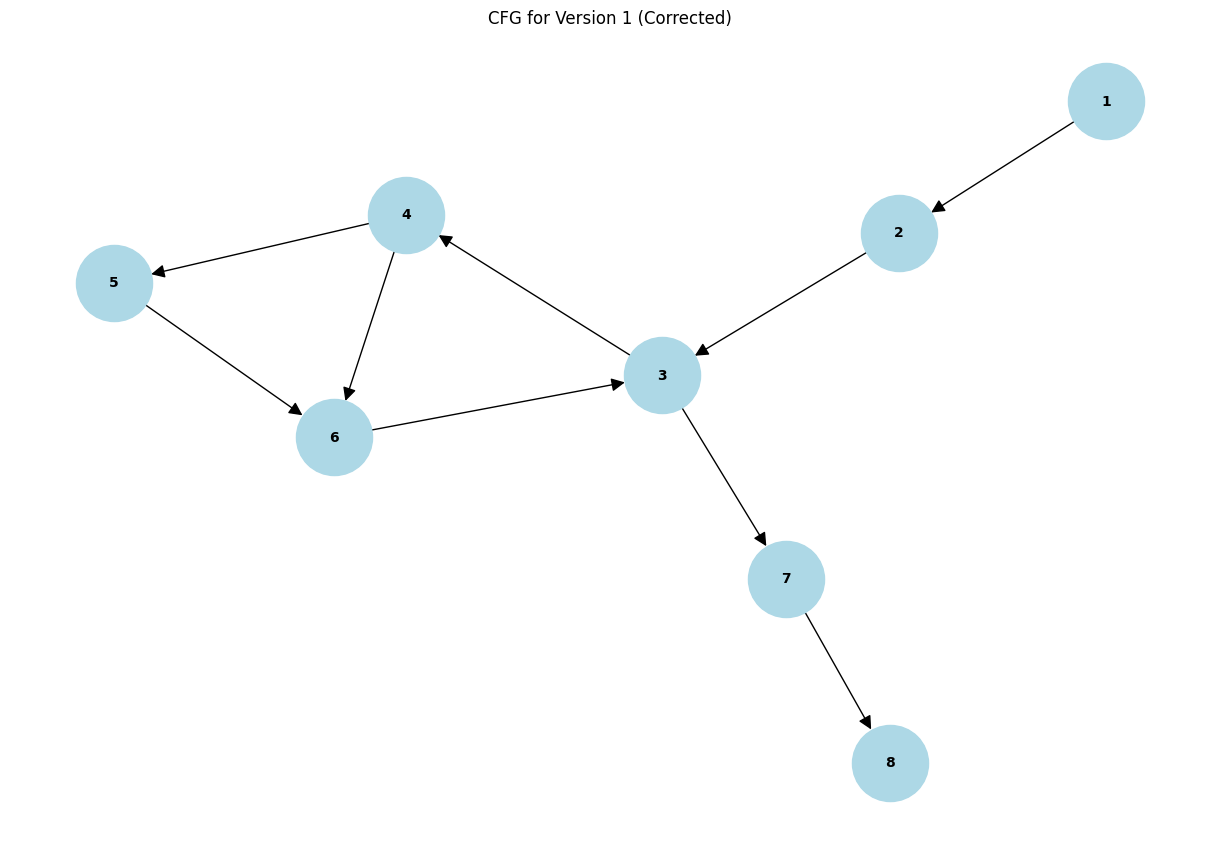

Node Number to Syntax Mapping:
1: entry
2: total = 0
3: for number in numbers
4: if number > 0
5: else
6: join
7: return total
8: exit
Number of independent paths for Version 1 (Corrected): 3

CFG for Version 2 (Corrected):


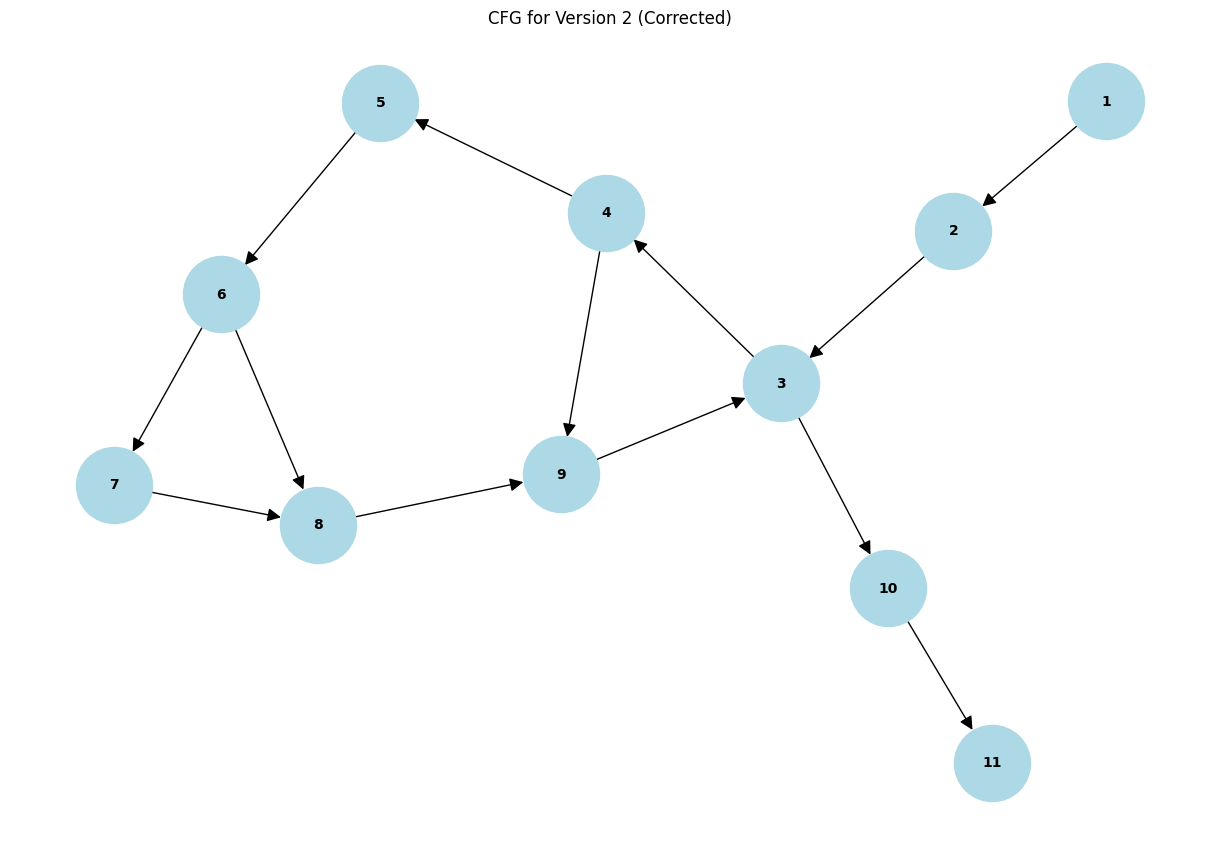

Node Number to Syntax Mapping:
1: entry
2: total = 0
3: for number in numbers
4: if number > 0
5: else
6: if number < 0
7: else
8: join
9: join
10: return total
11: exit
Number of independent paths for Version 2 (Corrected): 4

Comparison of CFGs (Version 1 and Version 2, Corrected):
Common Nodes:
('N2', frozenset({('subset', 1), ('label', 2), ('label_str', 'total = 0')}))
('N1', frozenset({('label', 1), ('label_str', 'entry'), ('subset', 0)}))
('N3', frozenset({('subset', 1), ('label', 3), ('label_str', 'for number in numbers')}))
('N5', frozenset({('label_str', 'else'), ('subset', 3), ('label', 5)}))
('N4', frozenset({('label_str', 'if number > 0'), ('subset', 2), ('label', 4)}))

Added Nodes:
('N9', frozenset({('label_str', 'join'), ('subset', 2), ('label', 9)}))
('N11', frozenset({('subset', 1), ('label_str', 'exit'), ('label', 11)}))
('N8', frozenset({('label_str', 'join'), ('subset', 3), ('label', 8)}))
('N7', frozenset({('label_str', 'else'), ('label', 7), ('subset', 4)}))
('N10

In [ ]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

class CFGBuilderCorrected(ast.NodeVisitor):
    def __init__(self):
        self.cfg = nx.DiGraph()
        self.current_node = None
        self.node_count = 0
        self.node_map = {}
        self.depth = 0  # Track the depth of each node for layout

    def add_node(self, label):
        self.node_count += 1
        node_name = f"N{self.node_count}"
        self.cfg.add_node(node_name, label=self.node_count, subset=self.depth, label_str=label)
        self.node_map[self.node_count] = label
        if self.current_node:
            self.cfg.add_edge(self.current_node, node_name)
        self.current_node = node_name
        return node_name

    def visit_FunctionDef(self, node):
        entry_node = self.add_node("entry")
        self.depth += 1
        self.current_node = entry_node
        self.generic_visit(node)
        self.add_node("exit")
        self.depth -= 1

    def visit_Assign(self, node):
        targets = [ast.unparse(t) for t in node.targets]
        value = ast.unparse(node.value)
        self.add_node(f"{targets[0]} = {value}")

    def visit_If(self, node):
        cond = ast.unparse(node.test)
        cond_node = self.add_node(f"if {cond}")
        current_node = self.current_node

        # Visit the body of the if statement
        self.depth += 1
        self.current_node = cond_node
        for stmt in node.body:
            self.visit(stmt)
        if_body_end = self.current_node

        # Visit the else part, if it exists
        self.current_node = cond_node
        else_node = self.add_node("else")
        if node.orelse:
            self.current_node = else_node
            for stmt in node.orelse:
                self.visit(stmt)
        else_body_end = self.current_node
        self.depth -= 1

        # Add a join node after if-else
        join_node = self.add_node("join")
        self.cfg.add_edge(if_body_end, join_node)
        self.cfg.add_edge(else_body_end, join_node)
        self.current_node = join_node

    def visit_While(self, node):
        cond = ast.unparse(node.test)
        cond_node = self.add_node(f"while {cond}")
        current_node = self.current_node

        # Visit the body of the while loop
        self.depth += 1
        for stmt in node.body:
            self.visit(stmt)
        body_end = self.current_node

        # Loop back to the condition node
        self.cfg.add_edge(body_end, cond_node)
        self.current_node = cond_node
        self.depth -= 1

    def visit_For(self, node):
        target = ast.unparse(node.target)
        iter_ = ast.unparse(node.iter)
        cond_node = self.add_node(f"for {target} in {iter_}")
        current_node = self.current_node

        # Visit the body of the for loop
        self.depth += 1
        for stmt in node.body:
            self.visit(stmt)
        body_end = self.current_node

        # Loop back to the condition node
        self.cfg.add_edge(body_end, cond_node)
        self.current_node = cond_node
        self.depth -= 1

    def visit_Return(self, node):
        value = ast.unparse(node.value)
        self.add_node(f"return {value}")

def generate_cfg_corrected(source_code):
    tree = ast.parse(source_code)
    cfg_builder = CFGBuilderCorrected()
    cfg_builder.visit(tree)
    return cfg_builder.cfg, cfg_builder.node_map

def visualize_cfg_corrected(cfg, title):
    pos = nx.kamada_kawai_layout(cfg)
    plt.figure(figsize=(12, 8))
    labels = nx.get_node_attributes(cfg, 'label')
    edge_labels = {(u, v): cfg[u][v].get('label', '') for u, v in cfg.edges()}
    nx.draw(cfg, pos, with_labels=True, labels=labels, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
    nx.draw_networkx_edge_labels(cfg, pos, edge_labels=edge_labels, font_color='red')
    plt.title(title)
    plt.show()

def print_node_map(node_map):
    print("Node Number to Syntax Mapping:")
    for node, syntax in node_map.items():
        print(f"{node}: {syntax}")

def compare_cfgs(cfg1, cfg2):
    def hashable_nodes(cfg):
        return set((node, frozenset(data.items())) for node, data in cfg.nodes(data=True))

    def hashable_edges(cfg):
        return set((u, v, frozenset(data.items())) for u, v, data in cfg.edges(data=True))

    # Compare nodes
    nodes1 = hashable_nodes(cfg1)
    nodes2 = hashable_nodes(cfg2)
    common_nodes = nodes1 & nodes2
    added_nodes = nodes2 - nodes1
    removed_nodes = nodes1 - nodes2

    # Compare edges
    edges1 = hashable_edges(cfg1)
    edges2 = hashable_edges(cfg2)
    common_edges = edges1 & edges2
    added_edges = edges2 - edges1
    removed_edges = edges1 - edges2

    print("Common Nodes:")
    for node in common_nodes:
        print(node)

    print("\nAdded Nodes:")
    for node in added_nodes:
        print(node)

    print("\nRemoved Nodes:")
    for node in removed_nodes:
        print(node)

    print("\nCommon Edges:")
    for edge in common_edges:
        print(edge)

    print("\nAdded Edges:")
    for edge in added_edges:
        print(edge)

    print("\nRemoved Edges:")
    for edge in removed_edges:
        print(edge)

def calculate_independent_paths(cfg):
    e = cfg.number_of_edges()
    n = cfg.number_of_nodes()
    independent_paths = e - n + 2
    return independent_paths

# Example usage with different code versions
version1_corrected = """
def process_numbers(numbers):
    total = 0
    for number in numbers:
        if number > 0:
            total += number
        else:
            total -= number
    return total
"""

version2_corrected = """
def process_numbers(numbers):
    total = 0
    for number in numbers:
        if number > 0:
            total += number
        elif number < 0:
            total -= number
        elseif
        else:
            total += 1  # Change: handling zero differently
    return total
"""

cfg1_corrected, node_map1_corrected = generate_cfg_corrected(version1_corrected)
cfg2_corrected, node_map2_corrected = generate_cfg_corrected(version2_corrected)

print("CFG for Version 1 (Corrected):")
visualize_cfg_corrected(cfg1_corrected, "CFG for Version 1 (Corrected)")
print_node_map(node_map1_corrected)
independent_paths1_corrected = calculate_independent_paths(cfg1_corrected)
print(f"Number of independent paths for Version 1 (Corrected): {independent_paths1_corrected}")

print("\nCFG for Version 2 (Corrected):")
visualize_cfg_corrected(cfg2_corrected, "CFG for Version 2 (Corrected)")
print_node_map(node_map2_corrected)
independent_paths2_corrected = calculate_independent_paths(cfg2_corrected)
print(f"Number of independent paths for Version 2 (Corrected): {independent_paths2_corrected}")

print("\nComparison of CFGs (Version 1 and Version 2, Corrected):")
compare_cfgs(cfg1_corrected, cfg2_corrected)
